In [206]:
# import packages
import numpy as np
import cv2
import glob
import pickle
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import time
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
from sklearn.utils import shuffle
# for scikit-learn >= 0.18 use:
from sklearn.model_selection import train_test_split


%matplotlib inline

In [207]:
def convert_color(img, conv='RGB2YCrCb'):
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv == 'BGR2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    if conv == 'RGB2LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
    if conv == 'BGR2HLS':
        return cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
    if conv == 'RGB2HLS':
        return cv2.cvtColor(img, cv2.COLOR_RGB2HLS)

def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=False, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=False, 
                       visualise=vis, feature_vector=feature_vec)
        return features

def bin_spatial(img, size=(32, 32)):
    color1 = cv2.resize(img[:,:,0], size).ravel()
    color2 = cv2.resize(img[:,:,1], size).ravel()
    color3 = cv2.resize(img[:,:,2], size).ravel()
    return np.hstack((color1, color2, color3))
                        
def color_hist(img, nbins=32):    #bins_range=(0, 256)
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, cspace='RGB2YCrCb', orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0, spatial_size=(32, 32),
                        hist_bins=32,): #hist_range=(0, 256)
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        # Read in each one by one
        image = mpimg.imread(file)
        feature_image = convert_color(image, cspace)
        feature_image = feature_image.astype(np.float32)/255      

        # Call get_hog_features() with vis=False, feature_vec=True
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))
            hog_features = np.ravel(hog_features)        
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        
        # Apply bin_spatial() to get spatial color features
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        # Apply color_hist() also with a color space option now
        hist_features = color_hist(feature_image, nbins=hist_bins) #bins_range=hist_range
        
        # Combine the features
        combined = np.hstack((spatial_features, hist_features, hog_features))
        # Append the new feature vector to the features list
        features.append(combined)

    # Return list of feature vectors
    return features

In [192]:
cars = []
notcars = []
cars = list(glob.iglob('dataset/vehicles/**/*.png'))
notcars = list(glob.iglob('dataset/non-vehicles/**/*.png'))

# For testing:::
#test_size = 2000
#cars = cars[:test_size]
#notcars = notcars[:test_size]

colorspace = 'RGB2YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
# HOG params
orient = 6
pix_per_cell = 8
cell_per_block = 2
hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"
# bin_spatial params
spatial_size = (64, 64)
# color_hist params
hist_bins = 16
hist_range = (0, 256)

t=time.time()
car_features = extract_features(cars, cspace=colorspace, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_size=spatial_size,
                        hist_bins=hist_bins) #hist_range=hist_range
notcar_features = extract_features(notcars, cspace=colorspace, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_size=spatial_size,
                        hist_bins=hist_bins) #hist_range=hist_range
t2 = time.time()
print(round(t2-t, 2), 'Seconds to extract HOG features...')
# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

#Shuffle and split up data into randomized training and test sets
scaled_X, y = shuffle(scaled_X, y, random_state=42)

train = int(len(scaled_X)*0.8)
test = int(len(scaled_X)*0.2)

X_train = scaled_X[:train]
y_train = y[:train]
X_test = scaled_X[-test:]
y_test = y[-test:]


print(np.shape(X_train))
print(np.shape(X_test))
print(np.shape(y_train))
print(np.shape(y_test))

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))
# Use a linear SVC 
svc = LinearSVC()

# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()
n_predict = 10
print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')

import pickle
p_save = {'svc': svc, 
          'scaler': X_scaler, 
          'orient': orient, 
          'pix_per_cell': pix_per_cell, 
          'cell_per_block': cell_per_block, 
          'spatial_size': spatial_size, 
          'hist_bins': hist_bins }

f = open('svc_pickle.p', 'wb')
pickle.dump(p_save, f)


90.19 Seconds to extract HOG features...
(14208, 15864)
(3552, 15864)
(14208,)
(3552,)
Using: 6 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 15864
55.19 Seconds to train SVC...
Test Accuracy of SVC =  0.9848
My SVC predicts:  [ 0.  1.  1.  1.  1.  1.  0.  1.  1.  1.]
For these 10 labels:  [ 0.  1.  1.  1.  1.  1.  0.  1.  1.  1.]
0.00277 Seconds to predict 10 labels with SVC


In [208]:
# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, draw_img, bboxes, ystart, ystop, scale, cells_per_step, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins):
    
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = convert_color(img_tosearch, conv='RGB2YCrCb')
    
    ctrans_tosearch = ctrans_tosearch.astype(np.float32)/255
    
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell)-1
    nyblocks = (ch1.shape[0] // pix_per_cell)-1 
    nfeat_per_block = orient*cell_per_block**2
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell)-1
    cells_per_step = cells_per_step # 2 # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step + 1
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step 
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    count_searches = 0
    count_found = 0
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell
            # This is just to exclude traffic coming against us as the classifier is detecting cars on that lane
            if xleft < 196:
                continue
            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
            
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)

            if test_prediction == 1:
                count_found += 1
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                test_arr.append(subimg)
                bboxes.append([(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)])
                cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(255,0,0),6) 
            count_searches += 1

    return count_searches, count_found

In [209]:
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,255,0), 6)
    # Return the image
    return img


In [222]:
heatmap_history = []
heatmap_sum = np.zeros((720,1280)).astype(np.float64)

def pipeline(im):
    # Global params to hold history and sum of heatmap through cycles
    global heatmap_history, heatmap_sum
    
    # import classifier and settings from pickle file
    dist_pickle = pickle.load( open("svc_pickle.p", "rb" ) )
    svc = dist_pickle["svc"]
    X_scaler = dist_pickle["scaler"]
    orient = dist_pickle["orient"]
    pix_per_cell = dist_pickle["pix_per_cell"]
    cell_per_block = dist_pickle["cell_per_block"]
    spatial_size = dist_pickle["spatial_size"]
    hist_bins = dist_pickle["hist_bins"]
    
    # prepare
    box_list = []    
    draw_img = np.copy(im)
    heat = np.zeros_like(im[:,:,0]).astype(np.float)
    img = im.astype(np.float32)/255
    
    # Search params
    first_search = {'ystart': 390 , 'ystop': 646, 'scale': 2.0, 'cells_per_step': 2}
    second_search = {'ystart': 390 , 'ystop': 518, 'scale': 1.2, 'cells_per_step': 2}
    
    # First search scale 2.0
    nmbr_of_search1, nmbr_of_found1 = find_cars(img, 
          draw_img,
          box_list, 
          first_search['ystart'], 
          first_search['ystop'], 
          first_search['scale'], 
          first_search['cells_per_step'],
          svc, X_scaler, orient, 
          pix_per_cell, cell_per_block, 
          spatial_size, hist_bins)
    
    # Second search scale 1.2
    nmbr_of_search2, nmbr_of_found2 = find_cars(img, 
          draw_img,
          box_list, 
          second_search['ystart'], 
          second_search['ystop'], 
          second_search['scale'], 
          second_search['cells_per_step'],
          svc, X_scaler, orient, 
          pix_per_cell, cell_per_block, 
          spatial_size, hist_bins)

    
    # Add heat to each box in box list
    heat = add_heat(heat,box_list)

    # Apply threshold to help remove false positives
    heat = apply_threshold(heat, 1.0)
    
    # Add heatmap to history. 
    heatmap_history.append(heat)
    # sum heatmap with latest heatmaps
    heatmap_sum += heat
    
    # remove from heatmap history if len > 10
    if len(heatmap_history) > 10:
        rem = heatmap_history.pop(0)
        heatmap_sum -= rem
    
    # Apply threshold to sum of heatmaps
    heatm_th = apply_threshold(heatmap_sum, 1.0)
    # Visualize the heatmap when displaying    
    heatmap = np.clip(heatm_th, 0, 255)
    
    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    #labels = label(average_heat)
    res = draw_labeled_bboxes(np.copy(im), labels)

    return res 

## Testing below

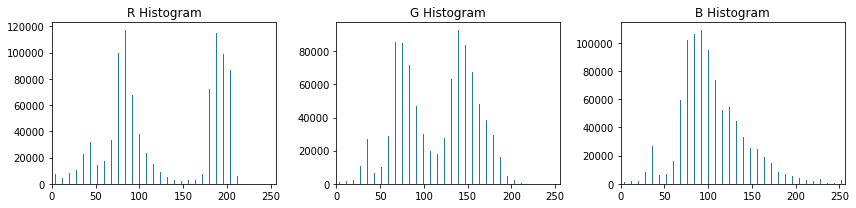

In [170]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

image = cv2.imread('test_images/test2.jpg')
feature_image = convert_color(img, 'RGB2YCrCb')
feature_image = feature_image.astype(np.float32)/255

# Define a function to compute color histogram features  
def color_hist(img, nbins=16, bins_range=(0, 256)):
    # Compute the histogram of the RGB channels separately
    rhist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    ghist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    bhist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Generating bin centers
    bin_edges = rhist[1]
    bin_centers = (bin_edges[1:]  + bin_edges[0:len(bin_edges)-1])/2
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((rhist[0], ghist[0], bhist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return rhist, ghist, bhist, bin_centers, hist_features
    
rh, gh, bh, bincen, feature_vec = color_hist(image, nbins=32, bins_range=(0, 256))

# Plot a figure with all three bar charts
if rh is not None:
    fig = plt.figure(figsize=(12,3))
    plt.subplot(131)
    plt.bar(bincen, rh[0])
    plt.xlim(0, 256)
    plt.title('R Histogram')
    plt.subplot(132)
    plt.bar(bincen, gh[0])
    plt.xlim(0, 256)
    plt.title('G Histogram')
    plt.subplot(133)
    plt.bar(bincen, bh[0])
    plt.xlim(0, 256)
    plt.title('B Histogram')
    plt.savefig('output_images/colorhist.png')
    fig.tight_layout()
else:
    print('Your function is returning None for at least one variable...')

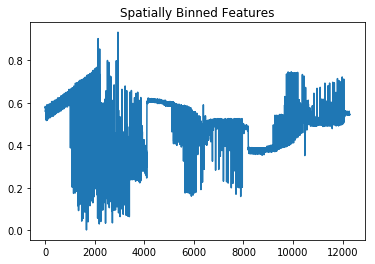

In [181]:
# Read in an image

image = cv2.imread('test_images/test2.jpg')
image = convert_color(image, 'RGB2YCrCb')
image = image.astype(np.float32)/255
    
feature_vec = bin_spatial(image, size=(64, 64))

# Plot features
plt.plot(feature_vec)
plt.title('Spatially Binned Features')
plt.savefig('output_images/bin_spat.png')

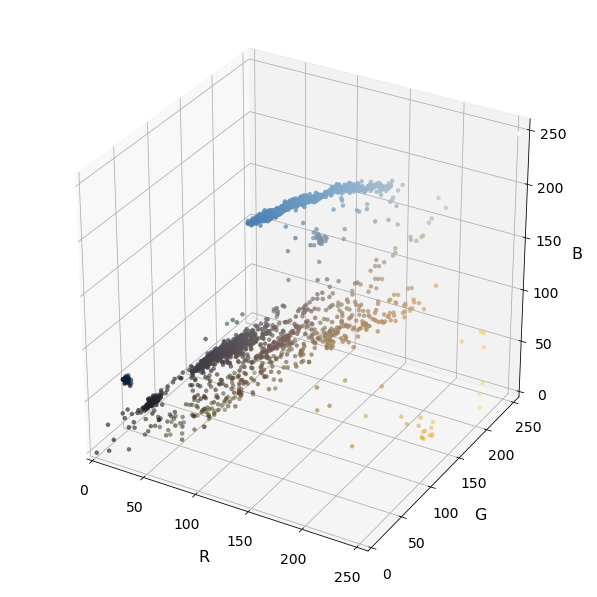

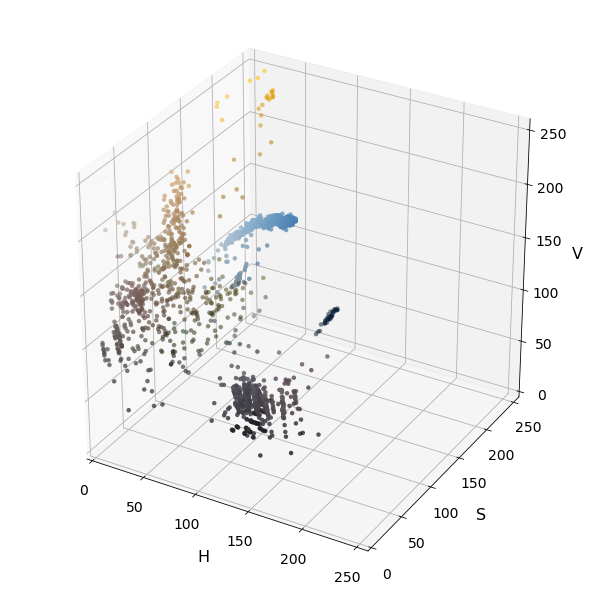

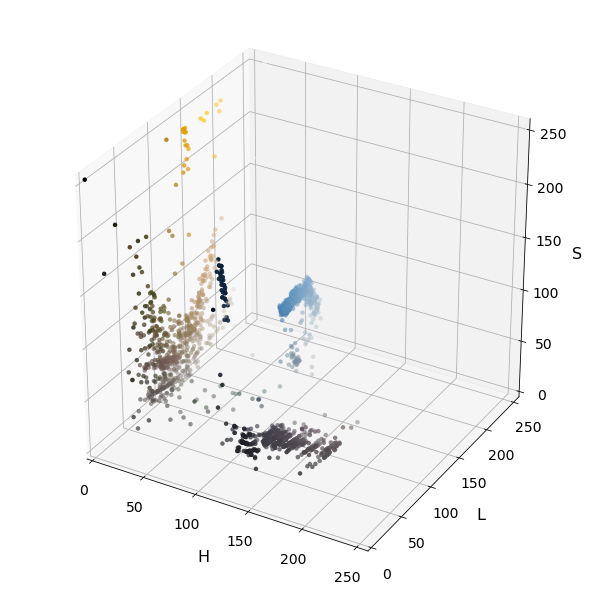

In [182]:
#Explore Color Spaces
#You can study the distribution of color values in an image by plotting each pixel in some color space. Here's a code snippet that you can use to generate 3D plots:

from mpl_toolkits.mplot3d import Axes3D

def plot3d(pixels, colors_rgb,
        axis_labels=list("RGB"), axis_limits=[(0, 255), (0, 255), (0, 255)]):
    """Plot pixels in 3D."""

    # Create figure and 3D axes
    fig = plt.figure(figsize=(8, 8))
    ax = Axes3D(fig)

    # Set axis limits
    ax.set_xlim(*axis_limits[0])
    ax.set_ylim(*axis_limits[1])
    ax.set_zlim(*axis_limits[2])

    # Set axis labels and sizes
    ax.tick_params(axis='both', which='major', labelsize=14, pad=8)
    ax.set_xlabel(axis_labels[0], fontsize=16, labelpad=16)
    ax.set_ylabel(axis_labels[1], fontsize=16, labelpad=16)
    ax.set_zlabel(axis_labels[2], fontsize=16, labelpad=16)

    # Plot pixel values with colors given in colors_rgb
    ax.scatter(
        pixels[:, :, 0].ravel(),
        pixels[:, :, 1].ravel(),
        pixels[:, :, 2].ravel(),
        c=colors_rgb.reshape((-1, 3)), edgecolors='none')

    return ax  # return Axes3D object for further manipulation


# Read a color image
img = cv2.imread('test_images/test2.jpg')

# Select a small fraction of pixels to plot by subsampling it
scale = max(img.shape[0], img.shape[1], 64) / 64  # at most 64 rows and columns
img_small = cv2.resize(img, (np.int(img.shape[1] / scale), np.int(img.shape[0] / scale)), interpolation=cv2.INTER_NEAREST)

# Convert subsampled image to desired color space(s)
img_small_RGB = cv2.cvtColor(img_small, cv2.COLOR_BGR2RGB)  # OpenCV uses BGR, matplotlib likes RGB
img_small_HSV = cv2.cvtColor(img_small, cv2.COLOR_BGR2HSV)
img_small_HLS = cv2.cvtColor(img_small, cv2.COLOR_BGR2HLS)
img_small_rgb = img_small_RGB / 255.  # scaled to [0, 1], only for plotting

# Plot and show
plot3d(img_small_RGB, img_small_rgb)
plt.show()

plot3d(img_small_HSV, img_small_rgb, axis_labels=list("HSV"))
plt.show()

plot3d(img_small_HLS, img_small_rgb, axis_labels=list("HLS"))
plt.show()

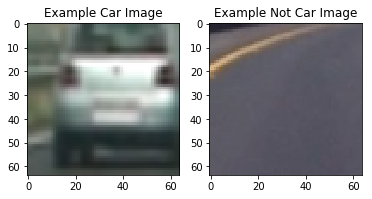

In [199]:
carex = mpimg.imread(cars[100])
notcarex = mpimg.imread(notcars[100])

fig = plt.figure()
plt.subplot(121)
plt.imshow(carex)
plt.title('Example Car Image')
plt.subplot(122)
plt.imshow(notcarex)
plt.title('Example Not Car Image')
plt.savefig('output_images/carnotcar.png')

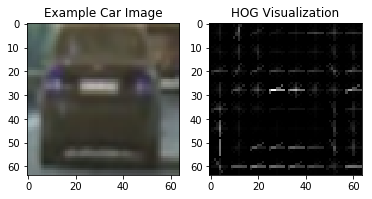

In [164]:
from skimage.feature import hog

        
# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True):
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=False, 
                                  visualise=True, feature_vector=False)
        return features, hog_image
    else:      
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=False, 
                       visualise=False, feature_vector=feature_vec)
        return features


# Read in the image
img = cv2.imread('dataset/vehicles/GTI_MiddleClose/image0001.png')
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
# Define HOG parameters
orient = 6
pix_per_cell = 8
cell_per_block = 2
# Call our function with vis=True to see an image output
features, hog_image = get_hog_features(gray, orient, 
                        pix_per_cell, cell_per_block, 
                        vis=True, feature_vec=False)


# Plot the examples
fig = plt.figure()
plt.subplot(121)
plt.imshow(img, cmap='gray')
plt.title('Example Car Image')
plt.subplot(122)
plt.imshow(hog_image, cmap='gray')
plt.title('HOG Visualization')
plt.savefig('output_images/hog_example.png')


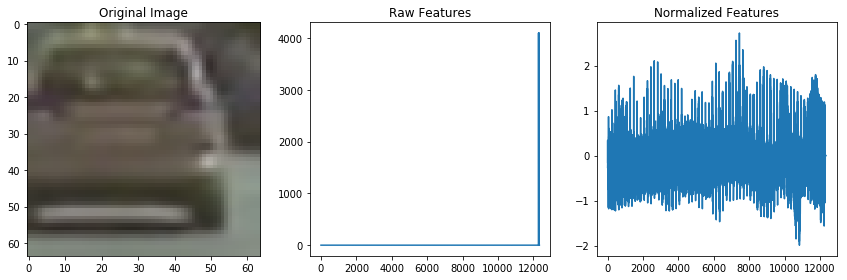

In [171]:
from sklearn.preprocessing import StandardScaler

# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

# Define a function to compute color histogram features  
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features


# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features_to_show(imgs, cspace='RGB2YCrCb', spatial_size=(64, 64),
                        hist_bins=16, hist_range=(0, 256)):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        # Read in each one by one
        image = cv2.imread(file)
        # apply color conversion
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        feature_image = convert_color(image, cspace)
        feature_image = feature_image.astype(np.float32)/255
          
        # Apply bin_spatial() to get spatial color features
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        # Apply color_hist() also with a color space option now
        hist_features = color_hist(feature_image, nbins=hist_bins, bins_range=hist_range)
        # Append the new feature vector to the features list
        combined = np.concatenate((spatial_features, hist_features))
        features.append(combined)
    # Return list of feature vectors
    return features


cars = []
notcars = []
cars = list(glob.iglob('dataset/vehicles/**/*.png'))
notcars = list(glob.iglob('dataset/non-vehicles/**/*.png'))

cars = cars[:10]
notcars = notcars[:10]
        
car_features = extract_features_to_show(cars, cspace='RGB2YCrCb', spatial_size=(64, 64),
                        hist_bins=16, hist_range=(0, 256))
notcar_features = extract_features_to_show(notcars, cspace='RGB2YCrCb', spatial_size=(64, 64),
                        hist_bins=16, hist_range=(0, 256))

if len(car_features) > 0:
    # Create an array stack of feature vectors
    X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
    # Fit a per-column scaler
    X_scaler = StandardScaler().fit(X)
    # Apply the scaler to X
    scaled_X = X_scaler.transform(X)
    car_ind = np.random.randint(0, len(cars))
    # Plot an example of raw and scaled features
    fig = plt.figure(figsize=(12,4))
    plt.subplot(131)
    plt.imshow(cv2.imread(cars[car_ind]))
    plt.title('Original Image')
    plt.subplot(132)
    plt.plot(X[car_ind])
    plt.title('Raw Features')
    plt.subplot(133)
    plt.plot(scaled_X[car_ind])
    plt.title('Normalized Features')
    fig.tight_layout()
    plt.savefig('output_images/color_spat_example.png')
else: 
    print('Your function only returns empty feature vectors...')

In [173]:
train = int(len(scaled_X)*0.8)
test = int(len(scaled_X)*0.2)

X_train = scaled_X[:train]
y_train = y[:train]
X_test = scaled_X[-test:]
y_test = y[-test:]


print(np.shape(X_train)) #X_train, X_test, y_train, y_test
print(np.shape(X_test))
print(np.shape(y_train))
print(np.shape(y_test))

(16, 12336)
(4, 12336)
(16,)
(4,)


Number of searchboxes : 322
Number of found : 19


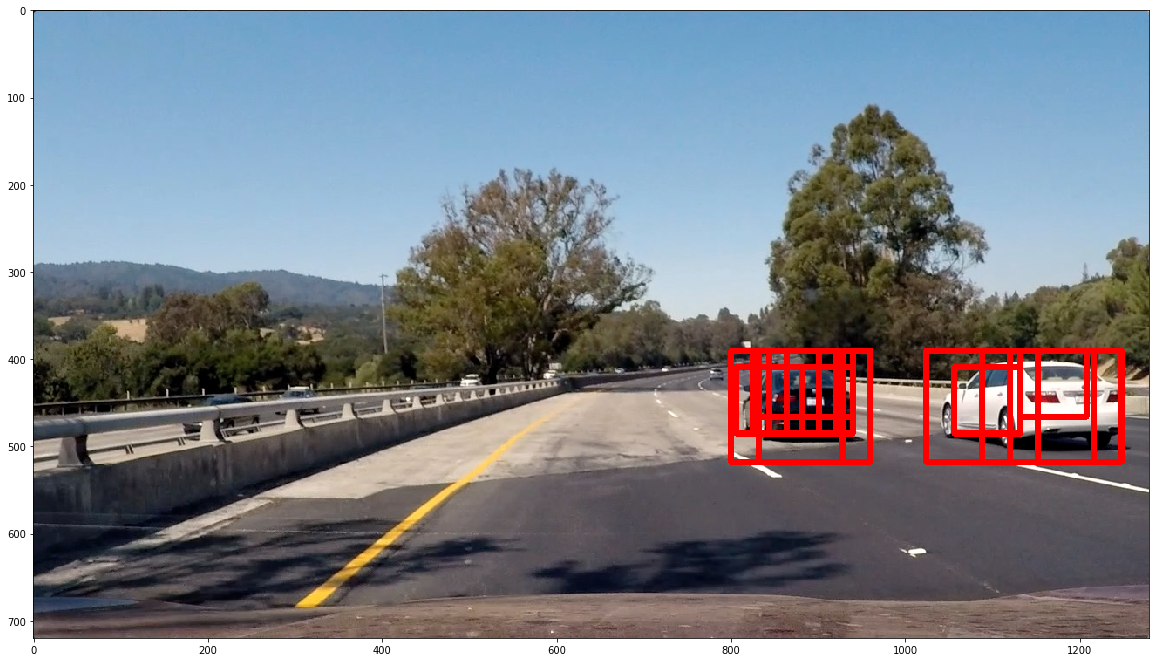

In [215]:
dist_pickle = pickle.load( open("svc_pickle.p", "rb" ) )
svc = dist_pickle["svc"]
X_scaler = dist_pickle["scaler"]
orient = dist_pickle["orient"]
pix_per_cell = dist_pickle["pix_per_cell"]
cell_per_block = dist_pickle["cell_per_block"]
spatial_size = dist_pickle["spatial_size"]
hist_bins = dist_pickle["hist_bins"]


test_arr = []
img = mpimg.imread('test_images/test4.jpg')
bboxes = []
draw_img = np.copy(img)
img = img.astype(np.float32)/255
#ystart = 444
#ystop = 700
#scale = 3.0
first_search = {'ystart': 390 , 'ystop': 646, 'scale': 2.0, 'nysteps': 2, 'cells_per_step': 2}
second_search = {'ystart': 390 , 'ystop': 518, 'scale': 1.2, 'nysteps': 1, 'cells_per_step': 2}
#third_search = {'ystart': 390 , 'ystop': 518, 'scale': 0.8, 'nysteps': 1, 'cells_per_step': 4}
# First search nearest
#out_img = find_cars(img, bboxes, first_search['ystart'], first_search['ystop'], first_search['scale'], svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
nmbr_of_search1, nmbr_of_found1 = find_cars(img, 
          draw_img,
          bboxes, 
          first_search['ystart'], 
          first_search['ystop'], 
          first_search['scale'], 
          first_search['cells_per_step'],
          svc, X_scaler, orient, 
          pix_per_cell, cell_per_block, 
          spatial_size, hist_bins) # 44 predicts

nmbr_of_search2, nmbr_of_found2 = find_cars(img, 
          draw_img,
          bboxes, 
          second_search['ystart'], 
          second_search['ystop'], 
          second_search['scale'], 
          second_search['cells_per_step'],
          svc, X_scaler, orient, 
          pix_per_cell, cell_per_block, 
          spatial_size, hist_bins) # 36 predicts

#nmbr_of_search3, nmbr_of_found3 = find_cars(img, 
#          draw_img,
#          bboxes, 
#          third_search['ystart'], 
#          third_search['ystop'], 
#          third_search['scale'], 
#          third_search['nysteps'],
#          third_search['cells_per_step'],
#          svc, X_scaler, orient, 
#          pix_per_cell, cell_per_block, 
#          spatial_size, hist_bins) # 78 predicts

### Total 158 predicts ###
print("Number of searchboxes : {}".format(nmbr_of_search1 + nmbr_of_search2 + nmbr_of_search3))
print("Number of found : {}".format(nmbr_of_found1 + nmbr_of_found2 + nmbr_of_found3))
plt.figure(figsize=(20,20))
plt.imshow(draw_img)
#plt.savefig('output_images/detection.png')


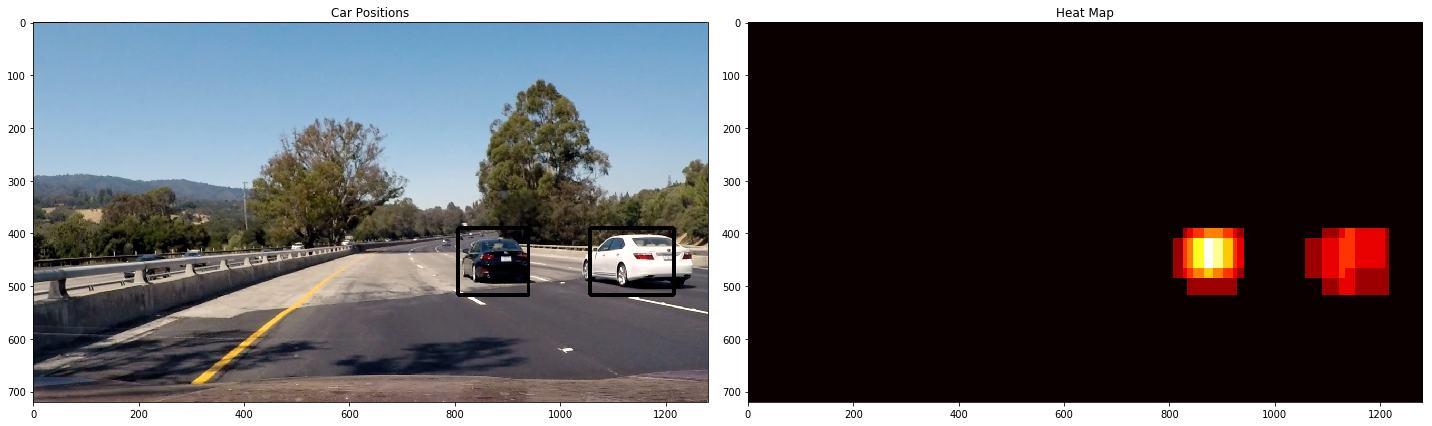

In [184]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import pickle
import cv2
from scipy.ndimage.measurements import label

# Read in a pickle file with bboxes saved
# Each item in the "all_bboxes" list will contain a 
# list of boxes for one of the images shown above
box_list = bboxes #pickle.load( open( "bbox_pickle.p", "rb" ))

# Read in image similar to one shown above 
image = mpimg.imread('test_images/test4.jpg')
heat = np.zeros_like(image[:,:,0]).astype(np.float)
image = image.astype(np.float32)/255


# Add heat to each box in box list
heat = add_heat(heat,box_list)
    
# Apply threshold to help remove false positives
heat = apply_threshold(heat, 1.0)

# Visualize the heatmap when displaying    
heatmap = np.clip(heat, 0, 255)

# Find final boxes from heatmap using label function
labels = label(heatmap)
draw_img = draw_labeled_bboxes(np.copy(image), labels)

#plt.figure(figsize=(20,20))
fig = plt.figure(figsize=(20,20))
plt.subplot(121)
plt.imshow(draw_img)
plt.title('Car Positions')
plt.subplot(122)
plt.imshow(heatmap, cmap='hot')
plt.title('Heat Map')
fig.tight_layout()
plt.savefig('output_images/heatmap_example.png')

In [211]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [223]:
# Video stuff
heatmap_history = []
heatmap_sum = np.zeros((720,1280)).astype(np.float64)
video_output = 'out_vid2.mp4'
#video_output = 'test_out.mp4'
clip1 = VideoFileClip('project_video.mp4')
#clip1 = VideoFileClip('test_video.mp4')
vid_clip = clip1.fl_image(pipeline)
%time vid_clip.write_videofile(video_output, audio=False)

[MoviePy] >>>> Building video out_vid2.mp4
[MoviePy] Writing video out_vid2.mp4


100%|█████████▉| 1260/1261 [07:10<00:00,  2.95it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: out_vid2.mp4 

CPU times: user 6min 50s, sys: 26.5 s, total: 7min 17s
Wall time: 7min 11s


In [224]:
# To view in notebook...
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(video_output))